In [1]:
# List of tickers we want. If None then all tickers are used.
tickers = ['LOW','DKS','KMB','HD']

### Simfin Load

In [2]:
#!pip install simfin
#!pip install yfinance --upgrade --no-cache-dir

In [2]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import numpy as np

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *
print (sf.__version__)
print (pd.__version__)

0.8.1
1.2.4


In [7]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')
sf.set_api_key(api_key='free')#'JpL0QY6C63I1qDXmNFRgz9U0iHVhBuhI')
# Seaborn set plotting style.
sns.set_style("whitegrid")

# Hub Settings (can change)

In [8]:
# We are interested in the US stock-market.
market = 'us'


# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=0)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [9]:
hub = sf.StockHub(market=market, tickers=tickers, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

In [14]:
df_prices_load = hub.load_shareprices(variant='daily')
df_prices = df_prices_load.copy().fillna(0)
#print (df_prices.head())

df_income_ttm_load = hub.load_income(variant='ttm')
df_income_ttm = df_income_ttm_load.copy().fillna(0)
#print (df_income_ttm.tail())

df_balance_load = hub.load_balance(variant='ttm')
df_balance = df_balance_load.copy().fillna(0)
#print (df_balance[[TOTAL_NONCUR_ASSETS,OTHER_LT_ASSETS]])

df_cashflow_load = hub.load_cashflow(variant='ttm')
df_cashflow = df_cashflow_load.copy().fillna(0)
#print (df_cashflow.tail())

df_companies = hub.load_companies()
#print (df_companies)

df_industries = sf.load_industries()
#print (df_industries)

#df_derived = hub.load_derived(variant='ttm')
#print (df_derived)

# df_derived_shareprices = hub.load_derived_shareprices(variant='daily')
# print (df_derived_shareprices)

Dataset "industries" on disk (0 days old).
- Loading from disk ... Done!


In [15]:
df_balance.index.droplevel(1).unique().to_list()

['LOW', 'DKS', 'KMB', 'HD']

In [17]:
moat_columns = ["EV+Div","Earnings","Sales","Cash"]
df_moat_perShare = pd.DataFrame(index=df_balance.index,columns=moat_columns)
df_moat_perShare["Sales"]=df_income_ttm[REVENUE]/df_income_ttm[SHARES_DILUTED]
df_moat_perShare["Earnings"]=df_income_ttm[NET_INCOME_COMMON]/df_income_ttm[SHARES_DILUTED]
df_moat_perShare["EV+Div"]=(df_balance[TOTAL_EQUITY]+df_cashflow[DIVIDENDS_PAID].fillna(0))/df_income_ttm[SHARES_DILUTED]
df_moat_perShare["Cash"]=(df_cashflow[NET_CASH_OPS])/df_income_ttm[SHARES_DILUTED]


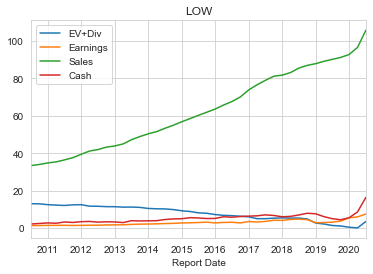

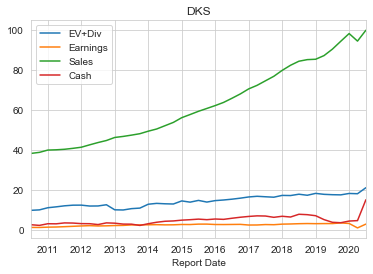

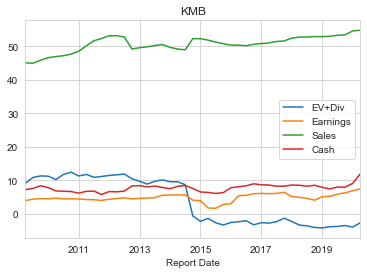

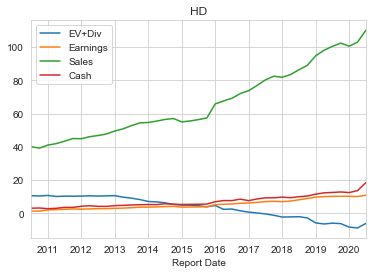

In [20]:
for ticker in tickers:
  df_moat_perShare.loc[ticker]['1990':].plot(title=ticker)


In [11]:
time_frames = [1,5,10]
columns = moat_columns
index = pd.MultiIndex.from_product([tickers, time_frames],names=('Ticker','Years'))
df_moat = pd.DataFrame(index=index, columns=columns)

In [12]:
def ann_rate_of_return(ending=1, beginning=1, years=1):
  if ending/beginning >= 0:
    rate = (ending/beginning)**(1/years) - 1
  else:
    rate = 0
  return rate

In [13]:
for ticker in tickers:
  for time_frame in time_frames:
    for moat_column in moat_columns:
      ending = df_moat_perShare.loc[ticker].iloc[-1][moat_column]
      beginning = df_moat_perShare.loc[ticker].iloc[-time_frame*4-1][moat_column]
      df_moat.loc[ticker, time_frame][moat_column]= ann_rate_of_return(ending,beginning,time_frame)
df_moat

EV+Div  Earnings     Sales       Cash
Ticker Years                                         
LOW    1     -0.331787  0.545313  0.321776   0.774653
       5     -0.200287  0.250399  0.141615   0.156276
       10    -0.139235  0.203655  0.136838   0.181983
DKS    1      0.545612  8.771118  0.381632  10.170347
       5      0.144022  0.312034  0.154199   0.541861
       10     0.101581  0.213788  0.121364   0.248941
KMB    1      0.189046 -0.210403  0.016493  -0.480349
       5      0.074961  0.017436  0.020219  -0.065989
       10    -0.097474  0.033285  0.010627  -0.013401
HD     1       2.27922  0.360841  0.275565   0.380919
       5      0.016324  0.203511  0.141516   0.137448
       10    -0.043572  0.199684   0.12054   0.175969

In [14]:
df_derived[BV_PS].loc['HD']

Report Date
2010-07-31    11.55377
2010-10-31    11.35601
2011-01-31    11.76760
2011-04-30    11.18500
2011-07-31    11.40810
2011-10-31    11.37034
2012-01-31    11.45839
2012-04-30    11.65127
2012-07-31    11.55570
2012-10-31    11.72567
2013-01-31    11.85924
2013-04-30    11.03534
2013-07-31    10.53821
2013-10-31     9.80952
2014-01-31     8.73374
2014-04-30     8.53549
2014-07-31     8.06405
2014-10-31     7.09474
2015-01-31     6.54175
2015-04-30     6.52535
2015-07-31     6.21032
2015-10-31     5.57658
2016-01-31     6.96712
2016-04-30     4.79652
2016-07-31     5.10115
2016-10-31     4.35730
2017-01-31     3.39311
2017-04-30     3.13387
2017-07-31     2.83809
2017-10-31     2.04874
2018-01-31     1.18308
2018-04-30     1.38648
2018-07-31     1.66895
2018-10-31     1.11722
2019-01-31    -1.65172
2019-04-30    -1.92586
2019-07-31    -1.06349
2019-10-31    -1.00255
2020-01-31    -2.85087
2020-04-30    -3.21363
2020-07-31    -0.38316
2020-10-31     1.42592
2021-01-31     3.07169

In [15]:
df_moat_pct_chg = df_moat_perShare.copy()
df_moat_pct_chg = df_moat_pct_chg.pct_change()
df_moat_pct_chg

EV+Div  Earnings     Sales      Cash
Ticker Report Date                                        
LOW    2010-07-31        NaN       NaN       NaN       NaN
       2010-10-31  -0.001968  0.046002  0.017779  0.137259
       2011-01-31  -0.015723  0.059449  0.023832  0.138403
       2011-04-30  -0.013930  0.006338  0.016520 -0.062427
       2011-07-31  -0.011272  0.025275  0.030395  0.146718
...                      ...       ...       ...       ...
HD     2020-04-30  -0.086336 -0.017345  0.023603  0.070845
       2020-07-31   1.250155  0.083196  0.069769  0.299238
       2020-10-31   0.364645  0.059969  0.056821  0.043049
       2021-01-31   0.244453  0.032254  0.054020 -0.047051
       2021-04-30  -0.141856  0.148209  0.070440  0.069313

[181 rows x 4 columns]

In [16]:
rate = ann_rate_of_return(0.382897,0.195138,10)
rate

0.06972959576014937

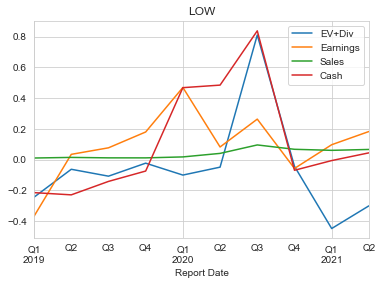

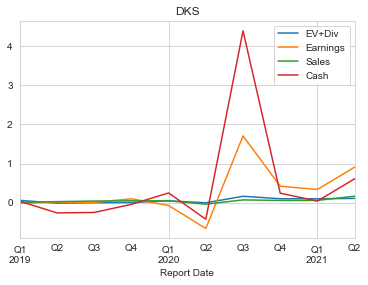

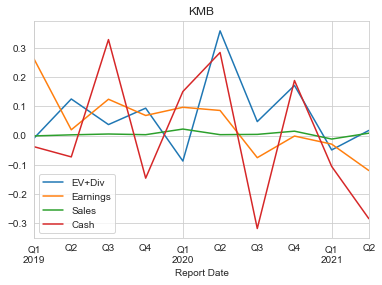

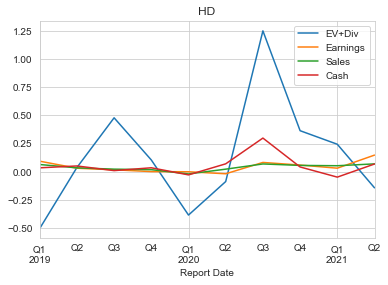

In [17]:
for ticker in tickers:
  df_moat_pct_chg.loc[ticker].iloc[-10:].plot(title=ticker)


In [18]:
mgt_columns = ("ROIC","ROE","LTD-to-FCF")
mgt_col_limits = (0.1,0.1,3)
df_mgt = pd.DataFrame(index=df_balance.index,columns=mgt_columns)
df_mgt["ROIC"]=(df_income_ttm[OP_INCOME]*(1+df_income_ttm[INCOME_TAX]/df_income_ttm[PRETAX_INCOME_LOSS]))/( (df_balance[LT_DEBT] + df_balance[ST_DEBT] + df_balance[TOTAL_EQUITY]))
df_mgt["ROE"]=df_derived[ROE]#df_income_ttm[NET_INCOME]/df_balance[TOTAL_EQUITY]
df_mgt["LTD-to-FCF"]=df_balance[LT_DEBT]/df_derived[FCF]#(df_cashflow[NET_CASH_OPS]-df_cashflow[CAPEX])

In [19]:
df_mgt

ROIC       ROE  LTD-to-FCF
Ticker Report Date                                
LOW    2010-07-31   0.083051   0.09733    1.329409
       2010-10-31   0.086584   0.10216    1.185827
       2011-01-31   0.089801   0.11098    1.250622
       2011-04-30   0.091223   0.11352    1.361800
       2011-07-31   0.093784   0.11800    1.227112
...                      ...       ...         ...
HD     2020-04-30   0.366881  -3.14441    1.578180
       2020-07-31   0.370476 -28.56763    1.249759
       2020-10-31   0.365124   8.13681    1.219758
       2021-01-31   0.341691   3.89997    1.399844
       2021-04-30   0.419376   8.44737    1.268583

[181 rows x 3 columns]

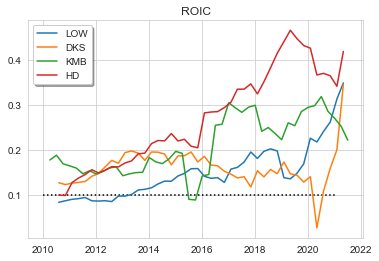

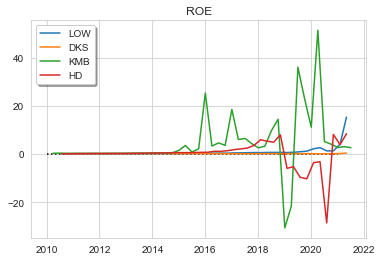

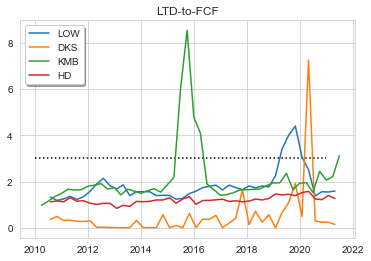

In [20]:
fig = []
ax = []

for column in mgt_columns:
  idx = mgt_columns.index(column)
  fig.append(idx)
  ax.append(idx)
  fig[idx], ax[idx] = plt.subplots()
  for ticker in tickers:
    ax[idx].plot(df_mgt.loc[ticker]['2010':][column],label=ticker)
  plt.hlines(mgt_col_limits[idx], xmin=datetime.datetime(2010,1,1), xmax=datetime.datetime(2020,12,31), linestyle = 'dotted',colors='k')
  legend = ax[idx].legend(loc='best', shadow=True)
  plt.title(column)
plt.show()

In [21]:
def rolling_40(df):
  return df.rolling(window=40,min_periods=1).mean()

In [22]:
df_balance.loc['HD'].iloc[-3][PPE_NET]-df_balance.loc['HD'].iloc[-7][PPE_NET]

1376000000.0

In [23]:
computed_columns = ['Sales','Sales_1y_change','PPE','Cash_Ops','Shares_Diluted','PPE/Sales','PPE/Sales_10y_mean','Growth_Capex','Maint_Capex','Owner_Earnings','Owner_Earnings_per_share','10Cap'
                    ,'FCF', 'FCF_per_share','Windage_Growth_Rate','Payback_Time'
                    ,'Default_PE','PE','PE_10y_mean','EPS','EPS_10y_est','Price_10y_est','Sticker_Price','MOS30','MOS50']
target_ROR = 0.15
df_computed = pd.DataFrame(index=df_income_ttm.index,columns=computed_columns)

# for 10 Cap calculation
df_computed['Sales'] = df_income_ttm[REVENUE]
df_computed['Sales_1y_change']= (df_computed['Sales']-df_computed['Sales'].shift(periods=4))
df_computed['PPE'] = -df_cashflow[CHG_FIX_ASSETS_INT]
df_computed['Cash_Ops'] = df_cashflow[NET_CASH_OPS]
df_computed['Shares_Diluted'] = df_income_ttm[SHARES_DILUTED]
df_computed['PPE/Sales'] = df_computed['Sales_1y_change']/df_computed['Sales']
df_computed['PPE/Sales_10y_mean'] = sf.apply(df=df_computed['PPE/Sales'],func=rolling_40)#df_computed['PPE/Sales'].rolling(window=10,min_periods=1).mean()
for ticker in tickers:
#  df_computed.loc[ticker,'PPE/Sales_10y_mean'] = df_computed.loc[ticker]['PPE/Sales'].rolling(window=10,min_periods=1).mean()#df_computed.loc[ticker][-10:]['PPE/Sales'].mean()
  df_computed.loc[ticker,'Windage_Growth_Rate'] = df_moat.loc[ticker,10]['EV+Div']
df_computed['Growth_Capex'] = df_computed['PPE'] * df_computed['PPE/Sales_10y_mean']
df_computed['Maint_Capex'] = df_computed['PPE'] - df_computed['Growth_Capex']
df_computed['Owner_Earnings'] = df_computed['Cash_Ops'] - df_computed['Maint_Capex']
df_computed['Owner_Earnings_per_share'] = df_computed['Owner_Earnings']/df_computed['Shares_Diluted']
df_computed['10Cap']=10*df_computed['Owner_Earnings_per_share']

# for payback time calculation
df_computed['FCF'] = df_cashflow[NET_CASH_OPS]-df_cashflow[CAPEX]
df_computed['FCF_per_share'] = df_computed['FCF']/df_computed['Shares_Diluted']
df_computed['Payback_Time']=df_computed['FCF_per_share']*((1+df_computed['Windage_Growth_Rate'])**8)

# for MOS calculation
df_computed['Default_PE']=2*df_computed['Windage_Growth_Rate']*100
df_computed['PE']=df_derived_shareprices[PE_TTM]
df_computed['PE_10y_mean']=sf.apply(df=df_computed['PE'],func=rolling_40)
df_computed['PE_10y_est'] = df_computed[['Default_PE','PE_10y_mean']].min(axis=1)
df_computed['EPS'] = df_derived['Earnings Per Share, Basic']
df_computed['EPS_10y_est'] = df_computed['EPS']*((1+df_computed['Windage_Growth_Rate'])**10)
df_computed['Price_10y_est'] = df_computed['EPS_10y_est']*df_computed['PE_10y_est']
df_computed['Sticker_Price'] = df_computed['Price_10y_est']/((1+target_ROR)**10)
df_computed['MOS50'] = df_computed['Sticker_Price']*0.5
df_computed['MOS30'] = df_computed['Sticker_Price']*0.7

df_computed[['Default_PE','PE','PE_10y_mean','PE_10y_est','EPS','EPS_10y_est','Price_10y_est','Sticker_Price','MOS30','MOS50']]
df_computed

Sales  Sales_1y_change           PPE     Cash_Ops  \
Ticker Report Date                                                             
LOW    2010-07-31   4.829200e+10              NaN  1.375000e+09   3120000000   
       2010-10-31   4.850400e+10              NaN  1.372000e+09   3520000000   
       2011-01-31   4.881500e+10              NaN  1.304000e+09   3852000000   
       2011-04-30   4.861200e+10              NaN  1.334000e+09   3539000000   
       2011-07-31   4.879400e+10     5.020000e+08  1.461000e+09   4363000000   
...                          ...              ...           ...          ...   
HD     2020-04-30   1.121040e+11     2.467000e+09  2.589000e+09  14849000000   
       2020-07-31   1.193180e+11     9.305000e+09  2.463000e+09  20019000000   
       2020-10-31   1.256310e+11     1.469700e+10  2.256000e+09  20309000000   
       2021-01-31   1.321100e+11     2.188500e+10  2.463000e+09  18839000000   
       2021-04-30   1.413500e+11     2.924600e+10  2.401000e+09  19412000000   

                    Shares_Diluted  PPE/Sales  PPE/Sales_10y_mean  \
Ticker Report Date                                                  
LOW    2010-07-31     1.446500e+09        NaN                 NaN   
       2010-10-31     1.427250e+09        NaN                 NaN   
       2011-01-31     1.403000e+09        NaN                 NaN   
       2011-04-30     1.374750e+09        NaN                 NaN   
       2011-07-31     1.339500e+09   0.010288            0.010288   
...                            ...        ...                 ...   
HD     2020-04-30     1.089750e+09   0.022006            0.119217   
       2020-07-31     1.084250e+09   0.077985            0.103147   
       2020-10-31     1.080250e+09   0.116985            0.088299   
       2021-01-31     1.078000e+09   0.165657            0.074379   
       2021-04-30     1.077500e+09   0.206905            0.061466   

                    Growth_Capex   Maint_Capex  Owner_Earnings  ...  \
Ticker Report Date                                              ...   
LOW    2010-07-31            NaN           NaN             NaN  ...   
       2010-10-31            NaN           NaN             NaN  ...   
       2011-01-31            NaN           NaN             NaN  ...   
       2011-04-30            NaN           NaN             NaN  ...   
       2011-07-31   1.503099e+07  1.445969e+09    2.917031e+09  ...   
...                          ...           ...             ...  ...   
HD     2020-04-30   3.086524e+08  2.280348e+09    1.256865e+10  ...   
       2020-07-31   2.540522e+08  2.208948e+09    1.781005e+10  ...   
       2020-10-31   1.992018e+08  2.056798e+09    1.825220e+10  ...   
       2021-01-31   1.831965e+08  2.279804e+09    1.655920e+10  ...   
       2021-04-30   1.475795e+08  2.253420e+09    1.715858e+10  ...   

                    Default_PE        PE  PE_10y_mean       EPS EPS_10y_est  \
Ticker Report Date                                                            
LOW    2010-07-31   -27.847021       NaN          NaN   1.29479    0.289098   
       2010-10-31   -27.847021       NaN          NaN   1.35415    0.302352   
       2011-01-31   -27.847021  18.74777    18.747770   1.43469    0.320334   
       2011-04-30   -27.847021       NaN    18.747770   1.44408    0.322431   
       2011-07-31   -27.847021       NaN    18.747770   1.48093    0.330659   
...                        ...       ...          ...       ...         ...   
HD     2020-04-30    -8.714337  21.37290    22.960269  10.10497     6.47231   
       2020-07-31    -8.714337  26.27320    23.067138  10.94586    7.010906   
       2020-10-31    -8.714337       NaN    23.067138  11.60242    7.431438   
       2021-01-31    -8.714337       NaN    22.925721  11.97952    7.672973   
       2021-04-30    -8.714337  27.01862    23.057750  13.75501    8.810188   

                   Price_10y_est Sticker_Price      MOS30     MOS50  \
Ticker Report Date                                               

In [24]:
df_computed[['Sales','Sales_1y_change']]

Sales  Sales_1y_change
Ticker Report Date                               
LOW    2010-07-31   4.829200e+10              NaN
       2010-10-31   4.850400e+10              NaN
       2011-01-31   4.881500e+10              NaN
       2011-04-30   4.861200e+10              NaN
       2011-07-31   4.879400e+10     5.020000e+08
...                          ...              ...
HD     2020-04-30   1.121040e+11     2.467000e+09
       2020-07-31   1.193180e+11     9.305000e+09
       2020-10-31   1.256310e+11     1.469700e+10
       2021-01-31   1.321100e+11     2.188500e+10
       2021-04-30   1.413500e+11     2.924600e+10

[181 rows x 2 columns]

In [25]:
(df_computed-df_computed.shift(periods=4)).head()

Sales  Sales_1y_change         PPE      Cash_Ops  \
Ticker Report Date                                                           
LOW    2010-07-31           NaN              NaN         NaN           NaN   
       2010-10-31           NaN              NaN         NaN           NaN   
       2011-01-31           NaN              NaN         NaN           NaN   
       2011-04-30           NaN              NaN         NaN           NaN   
       2011-07-31   502000000.0              NaN  86000000.0  1.243000e+09   

                    Shares_Diluted  PPE/Sales  PPE/Sales_10y_mean  \
Ticker Report Date                                                  
LOW    2010-07-31              NaN        NaN                 NaN   
       2010-10-31              NaN        NaN                 NaN   
       2011-01-31              NaN        NaN                 NaN   
       2011-04-30              NaN        NaN                 NaN   
       2011-07-31     -107000000.0        NaN                 NaN   

                    Growth_Capex  Maint_Capex  Owner_Earnings  ...  \
Ticker Report Date                                             ...   
LOW    2010-07-31            NaN          NaN             NaN  ...   
       2010-10-31            NaN          NaN             NaN  ...   
       2011-01-31            NaN          NaN             NaN  ...   
       2011-04-30            NaN          NaN             NaN  ...   
       2011-07-31            NaN          NaN             NaN  ...   

                    Default_PE  PE  PE_10y_mean      EPS EPS_10y_est  \
Ticker Report Date                                                     
LOW    2010-07-31          NaN NaN          NaN      NaN         NaN   
       2010-10-31          NaN NaN          NaN      NaN         NaN   
       2011-01-31          NaN NaN          NaN      NaN         NaN   
       2011-04-30          NaN NaN          NaN      NaN         NaN   
       2011-07-31          0.0 NaN          NaN  0.18614    0.041561   

                   Price_10y_est Sticker_Price     MOS30     MOS50  PE_10y_est  
Ticker Report Date                                                              
LOW    2010-07-31            NaN           NaN       NaN       NaN         NaN  
       2010-10-31            NaN           NaN       NaN       NaN         NaN  
       2011-01-31            NaN           NaN       NaN       NaN         NaN  
       2011-04-30            NaN           NaN       NaN       NaN         NaN  
       2011-07-31      -1.157348     -0.286079 -0.200255 -0.143039         0.0  

[5 rows x 26 columns]

In [26]:
MOS_columns = ['CurrentPrice','10Cap','Payback','MOS30','MOS50']
df_MOS = pd.DataFrame(index=tickers,columns=MOS_columns)
ytickers = dict.fromkeys(tickers)
for ticker in tickers:
  ytickers[ticker] = yf.Ticker(ticker)
  df_MOS.loc[ticker]['CurrentPrice'] = ytickers[ticker].info['currentPrice']
  df_MOS.loc[ticker]['10Cap'] = df_computed.loc[ticker].iloc[-1]['10Cap']
  df_MOS.loc[ticker]['Payback'] = df_computed.loc[ticker].iloc[-1]['Payback_Time']
  df_MOS.loc[ticker]['MOS30'] = df_computed.loc[ticker].iloc[-1]['MOS30']
  df_MOS.loc[ticker]['MOS50'] = df_computed.loc[ticker].iloc[-1]['MOS50']

df_MOS['Buy'] = np.where((df_MOS['CurrentPrice']<df_MOS['MOS30'])|(df_MOS['CurrentPrice']<df_MOS['10Cap'])|(df_MOS['CurrentPrice']<df_MOS['Payback']),True, False)

df_MOS

,CurrentPrice,10Cap,Payback,MOS30,MOS50,Buy
LOW,200.84,126.801381,5.240543,-9.93041,-7.09315,False
DKS,104.41,210.292232,56.011806,91.49655,65.354678,True
KMB,135.66,38.256395,4.339902,-7.132623,-5.09473,False
HD,332.84,159.244357,14.174819,-13.284314,-9.488796,False


In [27]:
df_income_banks = sf.load_income_banks(variant='annual', market='us')
df_balance_banks = sf.load_balance_banks(variant='annual', market='us')
df_balance_banks.loc['BAC']

Dataset "us-income-banks-annual" on disk (7 days old).
- Loading from disk ... Done!
Dataset "us-balance-banks-annual" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!


,SimFinId,Currency,Fiscal Year,Fiscal Period,Publish Date,Restated Date,Shares (Basic),Shares (Diluted),"Cash, Cash Equivalents & Short Term Investments",Interbank Assets,...,Total Deposits,Short Term Debt,Long Term Debt,Total Liabilities,Preferred Equity,Share Capital & Additional Paid-In Capital,Treasury Stock,Retained Earnings,Total Equity,Total Liabilities & Equity
Report Date,,,,,,,,,,,,,,,,,,,,,
2008-12-31,71941,USD,2008,Q4,2009-02-27,2010-02-26,4.592085e+09,4.596428e+09,3.285700e+10,8.247800e+10,...,8.829970e+11,4.163770e+11,2.682920e+11,1640891000000,3.770100e+10,7.676600e+10,NaN,7.382300e+10,177052000000,1817943000000
2009-12-31,71941,USD,2009,Q4,2010-02-26,2010-08-06,7.728570e+09,7.728570e+09,1.213390e+11,1.899330e+11,...,9.916110e+11,3.901410e+11,4.385210e+11,1991855000000,3.720800e+10,1.287340e+11,NaN,7.123300e+10,231444000000,2223299000000
2010-12-31,71941,USD,2010,Q4,2011-02-25,2012-02-23,9.790472e+09,9.790472e+09,1.084270e+11,2.096160e+11,...,1.010430e+12,3.773060e+11,4.484310e+11,2036661000000,1.656200e+10,1.509050e+11,NaN,6.084900e+10,228248000000,2264909000000
2011-12-31,71941,USD,2011,Q4,2012-02-23,2013-02-28,1.014262e+10,1.025482e+10,1.201020e+11,2.111830e+11,...,1.033041e+12,3.110700e+11,3.722650e+11,1898945000000,1.839700e+10,1.566210e+11,NaN,6.052000e+10,230101000000,2129046000000
2012-12-31,71941,USD,2012,Q4,2013-02-28,2014-02-25,1.074603e+10,1.084085e+10,1.107520e+11,2.199240e+11,...,1.105261e+12,3.975770e+11,2.755850e+11,1973018000000,1.876800e+10,1.581420e+11,NaN,6.284300e+10,236956000000,2209974000000
2013-12-31,71941,USD,2013,Q4,2014-02-25,2015-02-25,1.073116e+10,1.149142e+10,1.313220e+11,1.903280e+11,...,1.119271e+12,3.275740e+11,2.496740e+11,1869588000000,1.335200e+10,1.552930e+11,NaN,7.249700e+10,232685000000,2102273000000
2014-12-31,71941,USD,2014,Q4,2015-02-25,2016-02-24,1.052782e+10,1.058454e+10,1.385890e+11,1.918230e+11,...,1.118936e+12,3.066410e+11,2.431390e+11,1861063000000,1.930900e+10,1.534580e+11,NaN,7.502400e+10,243471000000,2104534000000
2015-12-31,71941,USD,2015,Q4,2016-02-24,2017-02-23,1.046228e+10,1.121399e+10,1.593530e+11,1.924820e+11,...,1.197259e+12,2.693520e+11,2.367640e+11,1888111000000,2.227300e+10,1.510420e+11,NaN,8.821900e+10,256176000000,2144287000000
2016-12-31,71941,USD,2016,Q4,2017-02-23,2017-05-02,1.028415e+10,1.103566e+10,1.477380e+11,1.982240e+11,...,1.260934e+12,2.572660e+11,2.168230e+11,1920862000000,2.522000e+10,1.470380e+11,NaN,1.018700e+11,266840000000,2187702000000
